# CNN with Pytorch for MNIST



### Submitted by - E20033 Shruti Nair

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import numpy as np
print("Torch Version:",torch.__version__)

Torch Version: 1.7.0+cu101


In [2]:
from torch import nn
import torch.nn.functional as F
from torchvision import datasets,transforms

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [24]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trainset=datasets.MNIST('~/.pytorch/MNIST_data/',train=True,transform=transform,download=True)
validset=datasets.MNIST('~/.pytorch/MNIST_data/',train=False,transform=transform,download=True)

train_loader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(validset,batch_size=64,shuffle=True,num_workers=0)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x
      
# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): B

In [26]:

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total_params",pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable_params",pytorch_total_params)

Total_params 187146
Trainable_params 187146


In [27]:
import torch.optim as optim
criterion = nn.NLLLoss()

# specify optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [28]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_mnist.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.621109 	Validation Loss: 0.092134
Validation loss decreased (inf --> 0.092134).  Saving model ...
Epoch: 2 	Training Loss: 0.128702 	Validation Loss: 0.046723
Validation loss decreased (0.092134 --> 0.046723).  Saving model ...
Epoch: 3 	Training Loss: 0.078366 	Validation Loss: 0.033182
Validation loss decreased (0.046723 --> 0.033182).  Saving model ...
Epoch: 4 	Training Loss: 0.059534 	Validation Loss: 0.028348
Validation loss decreased (0.033182 --> 0.028348).  Saving model ...
Epoch: 5 	Training Loss: 0.047576 	Validation Loss: 0.026262
Validation loss decreased (0.028348 --> 0.026262).  Saving model ...
Epoch: 6 	Training Loss: 0.038741 	Validation Loss: 0.022810
Validation loss decreased (0.026262 --> 0.022810).  Saving model ...
Epoch: 7 	Training Loss: 0.034623 	Validation Loss: 0.022053
Validation loss decreased (0.022810 --> 0.022053).  Saving model ...
Epoch: 8 	Training Loss: 0.029021 	Validation Loss: 0.019130
Validation loss decreased (0.02205

In [29]:
# specify the image classes
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

In [30]:
batch_size=16
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.016537

Test Accuracy of     0: 99% (260/262)
Test Accuracy of     1: 100% (301/301)
Test Accuracy of     2: 99% (274/276)
Test Accuracy of     3: 100% (232/232)
Test Accuracy of     4: 99% (240/241)
Test Accuracy of     5: 100% (213/213)
Test Accuracy of     6: 99% (217/219)
Test Accuracy of     7: 99% (261/262)
Test Accuracy of     8: 99% (238/240)
Test Accuracy of     9: 98% (263/266)

Test Accuracy (Overall): 99% (2499/2512)


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to de-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze())  # convert from Tensor image

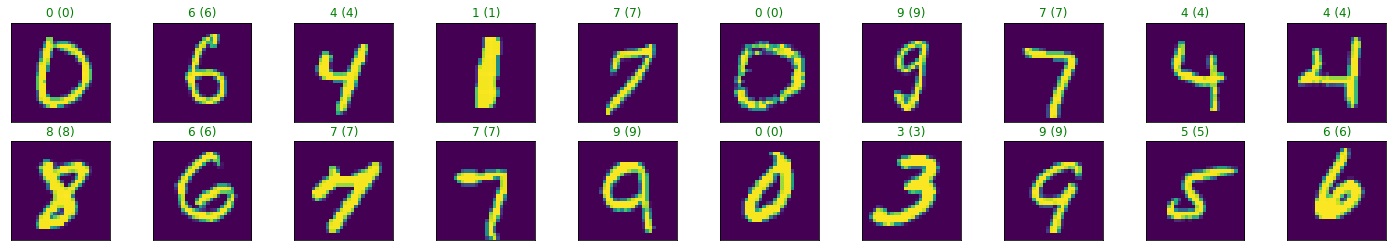

In [32]:
valid_loader=torch.utils.data.DataLoader(validset,batch_size=20,shuffle=True,num_workers=0)


# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images.numpy()


# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
